# DeepLabCut Toolbox - Demo for post processing for single animal projects with multiple circular ROIs
Nikola Bátová & Jesse ten Broeke

n.batova@student.rug.nl

j.ten.broeke1@student.rug.nl

Adjusted from demo by: https://github.com/AlexEMG/DeepLabCut

In [ ]:
# Importing the toolbox (takes several seconds)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Have this file in the same folder as the notebook
import time_in_each_roi
import time_within_certain_dist

import matplotlib
matplotlib.use('Agg')

from matplotlib.patches import Circle
from typing import Tuple, List, Dict
%matplotlib inline
import copy
from functions_for_DLC_analysis import get_bodyparts, create_rois, get_total_exploration_time, plot_rois_and_bpt_movements, plot_velocity_of_bpt

Import data from the videos folder created by the prject after training and analysis. This can be found by opening your project folder (Name_project_folder/videos). Add a path to the .h5 file of the video you want to analyze. There will be an additional name given after the original video title, this indicates the type of neural learning and the amount of training it had. Copy this in the DLCscorer variable as a str.

In [23]:
# Variable for the Dataframe to locate .h5 data
DLCscorer = 'DLC_resnet50_BN research projectFeb3shuffle1_54500'
# Loading DLC data to analyse
videoname = "233 (1)"
df= pd.read_hdf('../videos/233 (1)DLC_resnet50_BN research projectFeb3shuffle1_54500.h5')


Let's have a look at the data: Just for a visual queue and maybe for some direct insight for necessary calculations.

In [15]:
# Visualize data
df.head()

scorer    DLC_resnet50_BN research projectFeb3shuffle1_54500              \
bodyparts                                               nose               
coords                                                     x           y   
0                                                 675.028076  239.355667   
1                                                 674.955750  239.359833   
2                                                 674.973511  239.307877   
3                                                 674.955566  239.359329   
4                                                 675.005249  239.382996   

scorer                                                               \
bodyparts               left ear                          right ear   
coords    likelihood           x           y likelihood           x   
0           0.010837  666.744202  234.590118   0.010001  633.814514   
1           0.010633  666.723022  234.682510   0.010056  633.842773   
2           0.011103  666.739929  234.715546   0.010315  633.854309   
3           0.010979  666.750854  234.717468   0.010551  633.851562   
4           0.010611  666.782837  234.755676   0.010285  633.820496   

scorer                                        ...                  \
bodyparts                               neck  ... moved object 12   
coords              y likelihood           x  ...      likelihood   
0          264.873627   0.008853  641.405640  ...        0.976227   
1          264.833008   0.008954  641.415771  ...        0.975988   
2          264.783203   0.009046  641.444824  ...        0.975769   
3          264.739594   0.009041  641.467041  ...        0.975703   
4          264.743408   0.009065  641.484985  ...        0.976341   

scorer                                                                      \
bodyparts moved object 3                        moved object 6               
coords                 x           y likelihood              x           y   
0             394.376648  520.864319   0.983582     362.201569  561.903320   
1             394.408569  520.843262   0.983547     362.177734  561.935242   
2             394.414276  520.805969   0.983671     362.201935  561.968201   
3             394.402069  520.844421   0.983455     362.194580  561.945435   
4             394.440399  520.825134   0.983669     362.212555  561.982666   

scorer                                                      
bodyparts            moved object 9                         
coords    likelihood              x           y likelihood  
0           0.974823     327.461456  532.284241   0.982202  
1           0.974841     327.404541  532.273682   0.982267  
2           0.974781     327.398560  532.250977   0.982178  
3           0.975015     327.356232  532.260681   0.981958  
4           0.975171     327.331482  532.313660   0.981809  

[5 rows x 51 columns]

## Analysis of the amount of time spent in each region of interest

Functions to extract time spent by the mouse in each of a list of user defined ROIS


In [16]:
# Bugfix to take care of numpy nep50 warning.
def dummy_npwarn_decorator_factory():
  def npwarn_decorator(x):
    return x
  return npwarn_decorator
np._no_nep50_warning = getattr(np, '_no_nep50_warning', dummy_npwarn_decorator_factory)

Enter the name you gave your body part label
It is important this is the same for the extraction of the data from the .h5 file. 


In [17]:
# Frames per seconds in the videos being scored (default 30)
fps=30

# ADD body parts whose time you want to track in your ROI
bpt_plus_names=['nose', 'tail base']

# Ectract time, velocity & x and y coordinates for each body part
bpt_plus = get_bodyparts(df=df, DLCscorer=DLCscorer, fps=fps, bpt_names=bpt_plus_names)

# ADD body parts whose time you want to substract from the total time
bpt_minus_names=['left-front-paw', 'right-front-paw']

# Ectract time, velocity & x and y coordinates for each body part
bpt_minus = get_bodyparts(df=df, DLCscorer=DLCscorer, fps=fps, bpt_names=bpt_minus_names)

# Plotting the velocity per frame for the body part of interest. 

It can be helpful in finding some interactions or determining different interaction. A visualization tool for when speed is of the interest. 

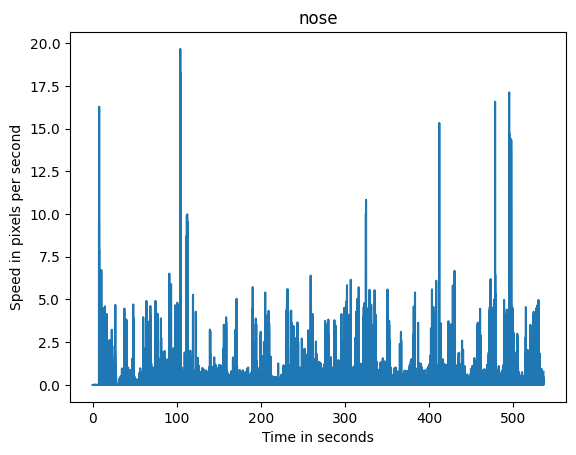

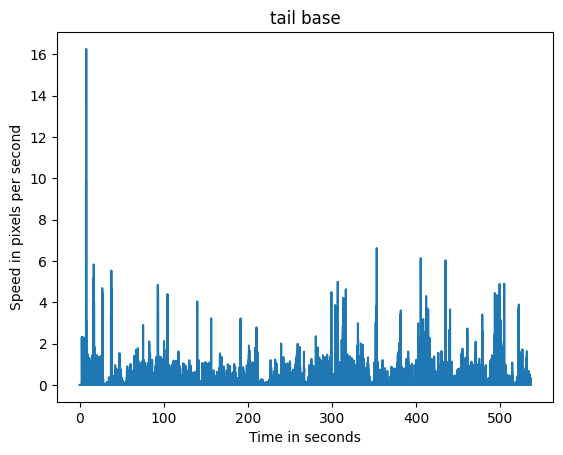

In [18]:
plot_velocity_of_bpt(bpts=bpt_plus, fps=fps)

## ADD ROIS
Here add the list of objects you want to track. The variable \code{boundary_size_distance} holds the distance from your object that you still consider ROI. It is important that your circular object is labelled 'centre', and then labels around the clock (12, 3, 6 and 9), labeled in the following way: 'Object A centre' or 'Object B 12'. 

In [29]:
# ADD a list of names of ROIs
rois_names = ['non-moved object', 'moved object']

# ADD how many cm from your object you want to track you body part, default 1
boundary_size_distance = 1

video_data = pd.read_csv(f'video_data.csv')

cm_to_pixel_ratio = video_data.loc[video_data['videoname'] == videoname, 'cm_to_pixel_ratio']
print(cm_to_pixel_ratio)

# Create a list of ROIs from the names
rois = create_rois(df=df, DLCscorer=DLCscorer, distance=boundary_size_distance, names=rois_names, cm_to_pixel_ratio=cm_to_pixel_ratio)

# Create rois for which time will be substracted if a certain body part is in one of these ROIs
rois_substracting = create_rois(df=df, DLCscorer=DLCscorer, distance=0, names=rois_names)

0    20.826215
Name: cm_to_pixel_ratio, dtype: float64


TypeError: create_rois() missing 1 required positional argument: 'cm_to_pixel_ratio'

Let's plot our ROIs on the in the area

In [ ]:
def plot_rois_and_bpt_movements(bpts, rois):
    for bpt in bpts:
        fig, ax = plt.subplots()  # Create a new figure for each body part

        # Add ROIs to the current figure
        for roi in rois:
            ax.add_patch(copy.deepcopy(roi.get("roi")))

        ax.set_aspect('equal')
        ax.set_facecolor('none')

        # Plot the current body part
        plt.plot(bpt.get("x"), bpt.get("y"), '.-', zorder=0)

        # Set limits and title for this body part
        plt.ylim(0, 700)
        plt.xlim(150, 1100)
        plt.title(bpt.get("name"))

        # Show each figure separately
        plt.show()

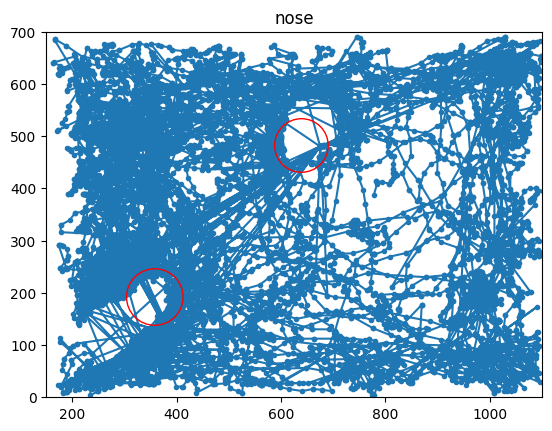

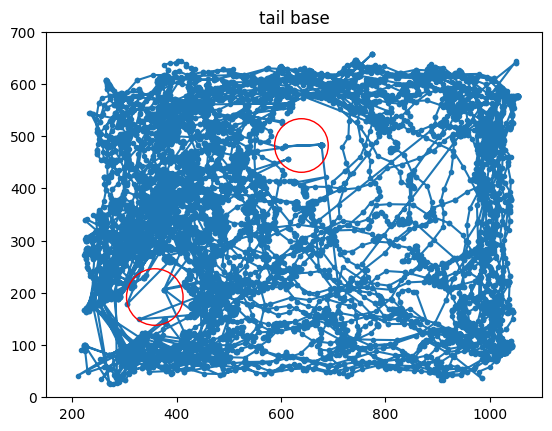

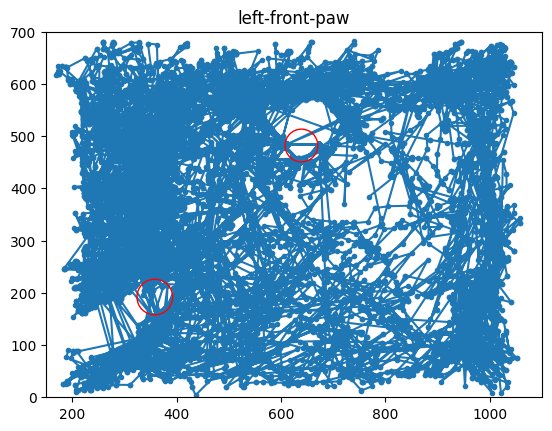

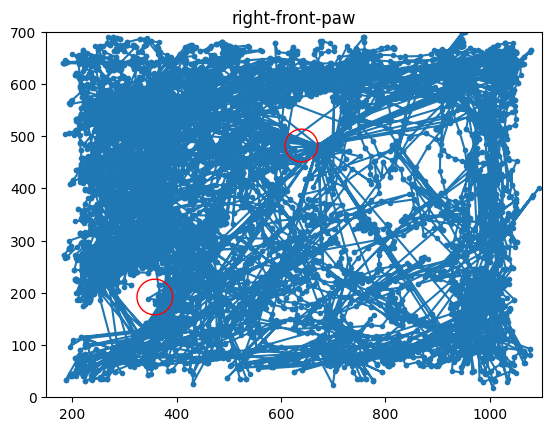

In [ ]:
# Plot ROISs to add up
plot_rois_and_bpt_movements(bpt_plus, rois)

# Plot ROIs to substract
plot_rois_and_bpt_movements(bpt_minus, rois_substracting)

Print out the time spent of the given body part in each ROI

In [ ]:
print("Added time:")
for roi in rois:
    print(f"{roi.get('name')}:")
    for bpt in bpt_plus:
        time_within_radius= time_within_certain_dist.calculate_time_within_distance(bpt.get('x'), bpt.get('y'), roi.get("center")[0], roi.get("center")[1], roi.get("radius"), min_frames=8, fps=30)
        print(f'{bpt.get("name")}: {time_within_radius}')
print('\n')
print("Time to be substracted:")
for roi in rois_substracting:
    for bpt in bpt_minus:
        time_within_radius= time_within_certain_dist.calculate_time_within_distance(bpt.get('x'), bpt.get('y'), roi.get("center")[0], roi.get("center")[1], roi.get("radius"), min_frames=8, fps=30)
        print(f'{bpt.get("name")}: {time_within_radius}')


Added time:
non-moved object:
nose: (12.900000000000004, 16.633333333333333)
tail base: (7.633333333333334, 7.766666666666667)
moved object:
nose: (5.666666666666667, 10.8)
tail base: (0.36666666666666664, 1.2666666666666666)


Time to be substracted:
left-front-paw: (5.366666666666667, 6.766666666666667)
right-front-paw: (0.3, 1.5666666666666667)
left-front-paw: (0.3, 1.4666666666666666)
right-front-paw: (0, 2.433333333333333)


Calculate total exploration time for each ROI

In [ ]:
get_total_exploration_time(rois, rois_substracting, bpt_plus, bpt_minus)

Total Exploration Time for non-moved object: 8.53333333333333s
Total Exploration Time for moved object: 6.999999999999999s
